# readme
descrip: plot Boston, New York SSH and AMOC Time Series for Sunway LR and HR (transient (TR) and control (CN))<br>

update history: <br>
v1.0 DL 2021Feb06 <br>
v1.1 DL 2021Mar03 <br>
v1.2 DL 2021Apr24 <br>
v1.3 DL 2021May06 make publication-ready pics <br>
v1.4 DL 2021Jun02 add TR minus CN plots <br>

extra notes: <br>
Fig 2 of the paper<br>
I used xoak to select cities from POP grids following https://pop-tools.readthedocs.io/en/latest/examples/xoak-example.html <br>
There is memory issue if use large data set files with xoak. I first use xoak with t12 and g16 grid files to get index for cities then select index for large data set files. 

# import modules

In [1]:
# general python packages
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# import cartopy
# import cartopy.crs as ccrs
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# python GCM(POP) packages
import xgcm
import pop_tools
import xoak
# import xesmf as xe

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
# from itertools import product
# from cftime import DatetimeNoLeap

# incorporate dask 

In [2]:
client = Client("tcp://10.73.2.132:37244")
client

Client Scheduler: tcp://10.73.2.132:37244 Dashboard: http://10.73.2.132:8787/status,Cluster Workers: 10 Cores: 10 Memory: 210.00 GB


# define parameters

In [3]:
chunks_HR = {'nlat':400,'nlon':300}
chunks_LR = {'nlat':384,'nlon':320}

# === AMOC files ===
indir = '/scratch/group/ihesp/archive/Sunway_Runs/'
# --- TH (transient HR), CH (control HR) ---
infile_MOC_CH=indir+'HR_PI_CTRL/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.MOC.002101.050112.nc'
infile_MOC_TH=indir+'HR_HF_TNST/B.E.13.BTRANS.ne120_t12.sehires38.003.sunway.pop.h.MOC.185001.210012.nc'
# infile_MHT_HR = '/ihesp/shared/HR_OMIP2-CMIP6/g.e20.G.TL319_t13.control.001.pop.h.012301-018312.N_HEAT.nc' # Meridional Heat Transport
# -----------------------------------------

# --- TL (transient LR), CL (control LR) ---
infile_MOC_TL=indir+'LR_HF_TNST/B.E.13.BTRANS.ne30g16.sehires38.003.sunway.pop.h.MOC.185001.210012.nc'
infile_MOC_CL=indir+'LR_PI_CTRL/B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.MOC.000101.050012.nc'
# ------------------------------------------
# ==================

# === POP grids files ===
infile0_g16 = ('/scratch/group/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
'POPgrids_gx1v6_2020Jun29.nc') # POP g16 grid file
infile0_t12 = ('/scratch/group/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
'POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
# =======================

outdir='/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic1 = outdir + 'SSHAMOCTimeSeriesSunwayTRCN_2021Jun02.png'

# read data files
read MOC files

In [4]:
ds_MOC_TL = xr.open_dataset(infile_MOC_TL)
time_s_TL = ds_MOC_TL.time.to_pandas().index.shift(-1,'M')  # convert FOSI time (model year) to actual year
ds_MOC_TL = ds_MOC_TL.assign_coords(time=time_s_TL)
ds_MOC_TL

<xarray.Dataset>
Dimensions:         (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, time: 3012, transport_reg: 2)
Coordinates:
  * time            (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
  * lat_aux_grid    (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z           (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: d2, moc_comp, transport_reg
Data variables:
    time_bound      (time, d2) object ...
    moc_components  (moc_comp) |S256 ...
    MOC             (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
Attributes:
    title:         B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-11 at 22:22:40.9
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  750
    tavg_sum:      2592000.0

In [5]:
ds_MOC_CL = xr.open_dataset(infile_MOC_CL)
print(ds_MOC_CL.time)
# 250-->1850, 500-->2100
# 1-->1601, # 1850-(250-1)=1601
time_MOC_CL = xr.cftime_range(start="1601-01", end="2101-01", freq='M', calendar='noleap')
ds_MOC_CL = ds_MOC_CL.assign_coords(time=time_MOC_CL)
ds_MOC_CL

<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 4, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(500, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(500, 12, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(501, 1, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0501-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound


<xarray.Dataset>
Dimensions:         (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nchar: 256, time: 6000, transport_reg: 2)
Coordinates:
  * time            (time) object 1601-01-31 00:00:00 ... 2100-12-31 00:00:00
  * lat_aux_grid    (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z           (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: d2, moc_comp, nchar, transport_reg
Data variables:
    time_bound      (time, d2) object ...
    moc_components  (moc_comp, nchar) |S1 ...
    MOC             (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
Attributes:
    title:           B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2020-03-12 at 12:53:17.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    750
    tavg_sum:        2592000.0
    tavg_sum_qflux:  2592000.0

In [6]:
ds_MOC_TH = xr.open_dataset(infile_MOC_TH)
time_s_TH = ds_MOC_TH.time.to_pandas().index.shift(-1,'M') # shift 1 mon
ds_MOC_TH = ds_MOC_TH.assign_coords(time=time_s_TH)
ds_MOC_TH

<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 1, moc_z: 63, time: 3012, transport_reg: 2)
Coordinates:
  * time               (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  (transport_reg) |S256 ...
    moc_components     (moc_comp) |S256 ...
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: moc_comp, transport_reg
Data variables:
    MOC                (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...

In [7]:
ds_MOC_CH = xr.open_dataset(infile_MOC_CH)
print(ds_MOC_CH.time)
# 250-->1850, 500-->2100
# 1-->1601, # 1850-(250-1)=1601
# 21-->1621,  501-->2101, 1850-(250-21)=1621
time_MOC_CH = xr.cftime_range(start="1621-01", end="2102-01", freq='M', calendar='noleap') 
ds_MOC_CH = ds_MOC_CH.assign_coords(time=time_MOC_CH)
ds_MOC_CH

<xarray.DataArray 'time' (time: 5772)>
array([cftime.DatetimeNoLeap(21, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(21, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(21, 4, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(501, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(501, 12, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(502, 1, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0021-02-01 00:00:00 ... 0502-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound


<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 1, moc_z: 63, time: 5772, transport_reg: 2)
Coordinates:
  * time               (time) object 1621-01-31 00:00:00 ... 2101-12-31 00:00:00
    transport_regions  (transport_reg) |S256 ...
    moc_components     (moc_comp) |S256 ...
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: moc_comp, transport_reg
Data variables:
    MOC                (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...

read SSH files

In [8]:
infile1_TH = ('/scratch/group/ihesp/archive/Sunway_Runs/HR_HF_TNST/'
              'B.E.13.BTRANS.ne120_t12.sehires38.003.sunway.pop.h.SSH.185001.210012.nc')
ds_TH = xr.open_dataset(infile1_TH, chunks=chunks_HR)
ds_TH

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 2400, nlon: 3600, time: 3012)
Coordinates:
  * time        (time) object 1850-02-01 00:00:00 ... 2100-12-17 00:00:00
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(3012, 2), meta=np.ndarray>
    SSH         (time, nlat, nlon) float32 dask.array<chunksize=(3012, 400, 300), meta=np.ndarray>
Attributes:
    title:           B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2019-10-29 at 17:54:15.4
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    19331
    tavg_sum:        2676600.0
    tavg_sum_qflux:  2676600.0
    NCO:             netCDF Operators version 4.9.1 (Homepage = http://nco.sf...

In [9]:
infile1_CH = ('/scratch/group/ihesp/archive/Sunway_Runs/HR_PI_CTRL/'
'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.SSH.0021.0501.nc')
ds_CH_raw = xr.open_dataset(infile1_CH, chunks=chunks_HR)
print(ds_CH_raw.time)
# 250-->1850, 500-->2100
# 21-->1621,  501-->2101, 1850-(250-21)=1621
time_CH = xr.cftime_range(start="1621", end="2102", freq='Y', calendar='noleap') 
# 2102 is not included, 2101 is the last year
ds_CH = ds_CH_raw.assign_coords(time=time_CH)
ds_CH

<xarray.DataArray 'time' (time: 481)>
array([cftime.DatetimeNoLeap(21, 7, 16, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(22, 7, 16, 22, 0, 0, 0),
       cftime.DatetimeNoLeap(23, 7, 16, 22, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(499, 7, 2, 5, 0, 0, 0),
       cftime.DatetimeNoLeap(500, 7, 2, 5, 0, 0, 0),
       cftime.DatetimeNoLeap(501, 7, 2, 5, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0021-07-16 22:00:00 ... 0501-07-02 05:00:00
Attributes:
    long_name:     time
    bounds:        time_bound
    cell_methods:  time: mean


<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 2400, nlon: 3600, time: 481)
Coordinates:
  * time        (time) object 1621-12-31 00:00:00 ... 2101-12-31 00:00:00
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(481, 2), meta=np.ndarray>
    SSH         (time, nlat, nlon) float32 dask.array<chunksize=(481, 400, 300), meta=np.ndarray>
Attributes:
    title:         B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2019-05-27 at 10:36:42.5
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  19331
    tavg_sum:      2676600.0
    history:       Thu May 21 22:18:12 2020: ncra -F -d time,1,12 B.E.13.B185...
    NCO:           netCDF Operators version 4.7.9 (Homepage = http://nco.sf.n...

In [10]:
infile1_TL = ('/scratch/group/ihesp/archive/Sunway_Runs/LR_HF_TNST/'
              'B.E.13.BTRANS.ne30g16.sehires38.003.sunway.pop.h.SSH.185001.210012.nc')
ds_TL = xr.open_dataset(infile1_TL,chunks=chunks_LR)
ds_TL

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 3012)
Coordinates:
  * time        (time) object 1850-01-17 12:00:00 ... 2100-12-17 00:00:00
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(3012, 2), meta=np.ndarray>
    SSH         (time, nlat, nlon) float32 dask.array<chunksize=(3012, 384, 320), meta=np.ndarray>
Attributes: (12/13)
    title:           B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:         Thu May 14 01:43:04 2020: ncra -O -v SSH /home/export/on...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2020-04-11 at 22:12:21.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    25
    tavg_sum:        86400.0
    tavg_sum_qflux:  86400.0
    NCO:             netCDF Operators version 4.9.1 (Homepage = http://nco.sf...

In [11]:
infile1_CL = ('/scratch/group/ihesp/archive/Sunway_Runs/LR_PI_CTRL/'
              'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.SSH.000101.050012.nc')
ds_CL_raw = xr.open_dataset(infile1_CL,chunks=chunks_LR)
print(ds_CL_raw.time)
# 250-->1850, 500-->2100
# 1-->1601, # 1850-(250-1)=1601
time_CL = xr.cftime_range(start="1601-01", end="2101-01", freq='M', calendar='noleap')
# 2101-01 is not included, the last time is 2100-12
ds_CL = ds_CL_raw.assign_coords(time=time_CL)
ds_CL

<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 4, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(500, 10, 17, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(500, 11, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(500, 12, 17, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0500-12-17 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound


<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 6000)
Coordinates:
  * time        (time) object 1601-01-31 00:00:00 ... 2100-12-31 00:00:00
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
    SSH         (time, nlat, nlon) float32 dask.array<chunksize=(6000, 384, 320), meta=np.ndarray>
Attributes:
    title:           B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2020-03-12 at 12:53:17.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    750
    tavg_sum:        2592000.0
    tavg_sum_qflux:  2592000.0

read grid files

In [12]:
ds0_g16 = xr.open_dataset(infile0_g16)
ds0_t12 = xr.open_dataset(infile0_t12)

In [13]:
grid_t12, xds_t12 = pop_tools.to_xgcm_grid_dataset(ds0_t12)
grid_g16, xds_g16 = pop_tools.to_xgcm_grid_dataset(ds0_g16)

_, xds_TH = pop_tools.to_xgcm_grid_dataset(ds_TH)
_, xds_CH = pop_tools.to_xgcm_grid_dataset(ds_CH)
_, xds_TL = pop_tools.to_xgcm_grid_dataset(ds_TL)
_, xds_CL = pop_tools.to_xgcm_grid_dataset(ds_CL)

In [14]:
xds_t12.xoak.set_index(['TLAT', 'TLONG'], 'scipy_kdtree')
xds_g16.xoak.set_index(['TLAT', 'TLONG'], 'scipy_kdtree')

In [15]:
# Boston (71.1W, 42.4N), New york (74.0W, 40.7N), 
# I adjust lat and lon a little because the original lat lon are on land (KMT=0)
cities_t12 = xds_t12.xoak.sel(
    TLONG=xr.Variable("cities", [-70.5+360, -74+360]),
    TLAT=xr.Variable("cities", [42.0, 40.5]))
# cities_t12

# I adjust lat and lon a little because the original lat lon are on land (KMT=0)
cities_g16 = xds_g16.xoak.sel(
    TLONG=xr.Variable("cities", [-70.5+360, -74+360]),
    TLAT=xr.Variable("cities", [42.0, 40.5]))
# cities_g16

In [16]:
print('real lon and lat for Boston and New York') # Boston (71.1W, 42.4N), New york (74.0W, 40.7N),
print([-71.1+360, 42.4])
print([-74+360, 40.7])

print('chosen lon and lat for Boston and New York (real lon and lat are not in the ocean)')
print([-70.5+360, 42])
print([-74+360, 40.5])

ssh_TH=xds_TH.sel(nlon_t=cities_t12.nlon_t.values,nlat_t=cities_t12.nlat_t.values).SSH
ssh_CH=xds_CH.sel(nlon_t=cities_t12.nlon_t.values,nlat_t=cities_t12.nlat_t.values).SSH
print('lon and lat on t12 grid')
print(ssh_TH.isel(nlon_t=0,nlat_t=0).TLONG.values,ssh_TH.isel(nlon_t=0,nlat_t=0).TLAT.values)
print(ssh_TH.isel(nlon_t=1,nlat_t=1).TLONG.values,ssh_TH.isel(nlon_t=1,nlat_t=1).TLAT.values)

ssh_TL=xds_TL.sel(nlon_t=cities_g16.nlon_t.values,nlat_t=cities_g16.nlat_t.values).SSH
ssh_CL=xds_CL.sel(nlon_t=cities_g16.nlon_t.values,nlat_t=cities_g16.nlat_t.values).SSH
print('lon and lat on g16 grid')
print(ssh_TL.isel(nlon_t=0,nlat_t=0).TLONG.values,ssh_TL.isel(nlon_t=0,nlat_t=0).TLAT.values)
print(ssh_TL.isel(nlon_t=1,nlat_t=1).TLONG.values,ssh_TL.isel(nlon_t=1,nlat_t=1).TLAT.values)

ssh_TH

real lon and lat for Boston and New York
[288.9, 42.4]
[286, 40.7]
chosen lon and lat for Boston and New York (real lon and lat are not in the ocean)
[289.5, 42]
[286, 40.5]
lon and lat on t12 grid
289.4927248651452 42.000363243223966
285.9800385551817 40.5009890332746
lon and lat on g16 grid
289.87680609401775 41.92955449401052
286.4429434610795 40.32675645820816


<xarray.DataArray 'SSH' (time: 3012, nlat_t: 2, nlon_t: 2)>
dask.array<getitem, shape=(3012, 2, 2), dtype=float32, chunksize=(3012, 2, 2), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-02-01 00:00:00 ... 2100-12-17 00:00:00
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
  * nlon_t   (nlon_t) float64 403.5 366.5
  * nlat_t   (nlat_t) float64 1.65e+03 1.634e+03
Attributes:
    long_name:     Sea Surface Height
    units:         centimeter
    grid_loc:      2110
    cell_methods:  time: mean

In [17]:
ssh_yr_TH = ssh_TH.sel(time=slice('1850','2100')).resample(time='A').mean('time')
ssh_yr_CH = ssh_CH.sel(time=slice('1850','2100')) # already yearly data (only CH is yearly data), no need to resample
ssh_yr_TL = ssh_TL.sel(time=slice('1850','2100')).resample(time='A').mean('time')
ssh_yr_CL = ssh_CL.sel(time=slice('1850','2100')).resample(time='A').mean('time')
ssh_yr_TH

<xarray.DataArray 'SSH' (time: 251, nlat_t: 2, nlon_t: 2)>
dask.array<stack, shape=(251, 2, 2), dtype=float32, chunksize=(1, 2, 2), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2100-12-31 00:00:00
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
  * nlon_t   (nlon_t) float64 403.5 366.5
  * nlat_t   (nlat_t) float64 1.65e+03 1.634e+03

In [18]:
MOC45_yr_TL = (ds_MOC_TL.MOC.sel(lat_aux_grid=45, moc_z=1000*100,
    method='nearest').sel(moc_comp=0, transport_reg=1, time=slice('1850','2100')).resample(time='A').mean('time'))
MOC45_yr_TH = (ds_MOC_TH.MOC.sel(lat_aux_grid=45, moc_z=1000*100,
    method='nearest').sel(moc_comp=0, transport_reg=1, time=slice('1850','2100')).resample(time='A').mean('time'))
MOC45_yr_TH

<xarray.DataArray 'MOC' (time: 251)>
array([15.120004 , 16.444918 , 17.04949  , 18.745255 , 18.02128  ,
       17.472525 , 19.309134 , 19.298847 , 16.547194 , 16.44132  ,
       17.866838 , 18.447832 , 18.24583  , 18.666765 , 19.489471 ,
       19.552494 , 18.886652 , 19.064049 , 20.06567  , 17.005636 ,
       18.355825 , 17.033075 , 15.549595 , 17.188482 , 17.022575 ,
       16.267538 , 15.423226 , 14.98082  , 16.338614 , 16.746784 ,
       16.724062 , 16.204107 , 17.77412  , 17.159117 , 17.709124 ,
       17.061163 , 16.997816 , 17.2236   , 17.453753 , 16.159822 ,
       18.948645 , 17.954468 , 18.067192 , 16.329098 , 16.063047 ,
       18.57193  , 17.360264 , 16.450151 , 15.205365 , 14.858092 ,
       16.542517 , 17.500652 , 18.101244 , 18.862825 , 19.317232 ,
       18.80632  , 18.272478 , 16.68756  , 18.833189 , 18.491484 ,
       16.604101 , 17.218168 , 15.859653 , 16.82247  , 14.904725 ,
       15.893887 , 17.2852   , 18.015795 , 16.249424 , 16.856848 ,
       14.396205 , 15.207012 , 17.637775 , 16.33367  , 14.221154 ,
       15.831758 , 15.293419 , 16.43131  , 16.830643 , 16.169401 ,
       16.950922 , 18.741636 , 15.779613 , 16.471302 , 16.107237 ,
       17.709185 , 19.629225 , 18.164423 , 16.942123 , 16.642088 ,
       19.177687 , 18.089403 , 17.240276 , 16.964226 , 16.677599 ,
       16.16825  , 15.707332 , 15.487254 , 15.890788 , 15.181844 ,
...
       16.957977 , 16.74568  , 16.416965 , 16.075766 , 17.299227 ,
       16.092182 , 16.73659  , 16.327955 , 16.596039 , 16.596071 ,
       14.964383 , 16.152273 , 15.720402 , 17.338995 , 16.311857 ,
       15.356696 , 14.643234 , 15.046252 , 14.98606  , 16.172945 ,
       16.442118 , 14.941468 , 14.686905 , 14.813628 , 12.498653 ,
       14.92043  , 15.647316 , 15.883114 , 16.8997   , 15.066585 ,
       16.16576  , 13.644112 , 14.594521 , 14.220506 , 13.649962 ,
       15.2827635, 12.606927 , 13.637975 , 12.573555 , 13.209984 ,
       14.42694  , 13.5409155, 14.508102 , 13.067329 , 13.729637 ,
       13.38221  , 14.207676 , 14.7184515, 14.494476 , 13.966252 ,
       13.6609335, 14.633298 , 12.829087 , 12.182702 , 12.118396 ,
       12.568867 , 13.099486 , 12.045475 , 11.895144 , 12.668895 ,
       14.085106 , 13.594117 , 13.243449 , 12.917737 , 11.162582 ,
       12.826046 , 11.664776 , 10.890426 , 10.397122 , 11.11139  ,
       11.858224 , 11.471057 , 12.16995  , 12.725026 , 11.236511 ,
       11.698628 , 11.909004 , 10.953728 , 11.494975 , 10.774434 ,
       10.411097 , 10.7522745, 10.278907 ,  9.243911 ,  9.131544 ,
       11.00893  , 10.387916 ,  9.752358 ,  9.703551 ,  9.887286 ,
       10.637841 ,  9.851748 ,  7.3754783, 10.189496 ,  9.702498 ,
        9.248578 ], dtype=float32)
Coordinates:
  * time               (time) object 1850-12-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador ...
    moc_components     |S256 b'Eulerian Mean'
    moc_z              float32 1.041e+05
    lat_aux_grid       float32 44.76

In [19]:
MOC45_yr_CL = (ds_MOC_CL.MOC.sel(lat_aux_grid=45, moc_z=1000*100, method='nearest').sel(
    moc_comp=0, transport_reg=1).sel(time=slice('1850','2100')).resample(time='A').mean('time'))
MOC45_yr_CH = (ds_MOC_CH.MOC.sel(lat_aux_grid=45, moc_z=1000*100, method='nearest').sel(
    moc_comp=0, transport_reg=1).sel(time=slice('1850','2100')).resample(time='A').mean('time'))
MOC45_yr_CH

<xarray.DataArray 'MOC' (time: 251)>
array([14.737906 , 15.778675 , 16.669935 , 17.549597 , 18.107977 ,
       19.70096  , 20.196753 , 17.757113 , 17.901491 , 18.815481 ,
       15.854851 , 17.99136  , 19.490707 , 19.458567 , 16.850134 ,
       17.760893 , 18.888737 , 17.156462 , 16.249989 , 16.705202 ,
       18.01807  , 17.08821  , 15.352584 , 16.699097 , 16.694403 ,
       15.870086 , 18.35326  , 17.56015  , 17.924364 , 16.63582  ,
       16.273863 , 17.128468 , 16.446398 , 15.5597925, 17.979883 ,
       16.756975 , 17.862429 , 17.182348 , 17.790241 , 17.724213 ,
       17.849972 , 17.307213 , 18.782099 , 17.64312  , 17.227911 ,
       14.306367 , 16.46192  , 15.499446 , 16.84981  , 15.898164 ,
       15.711895 , 17.600012 , 19.875805 , 18.96318  , 16.882956 ,
       18.414276 , 18.3565   , 18.002132 , 18.485292 , 17.07608  ,
       16.904043 , 17.89406  , 16.071905 , 16.883541 , 16.722755 ,
       14.917775 , 16.152937 , 16.428804 , 16.93987  , 17.731165 ,
       17.586685 , 17.047867 , 17.28553  , 15.78384  , 17.11745  ,
       17.26727  , 16.99177  , 16.826544 , 14.875197 , 15.098518 ,
       16.209572 , 16.438963 , 15.668476 , 15.00977  , 15.366188 ,
       16.209211 , 16.21887  , 17.863462 , 17.469637 , 15.871525 ,
       16.996758 , 15.7471285, 16.605032 , 14.095641 , 13.610722 ,
       15.703313 , 16.808527 , 15.641094 , 15.186272 , 16.704012 ,
...
       16.623068 , 15.48726  , 15.010497 , 16.288404 , 16.067293 ,
       17.597128 , 17.945097 , 16.991247 , 18.02287  , 17.857824 ,
       15.629807 , 14.709565 , 15.29121  , 17.31498  , 15.518951 ,
       17.264135 , 17.740755 , 15.960709 , 16.992296 , 15.8122835,
       16.51659  , 16.45621  , 15.945292 , 16.11159  , 16.334864 ,
       16.306673 , 16.27603  , 16.013609 , 15.932195 , 15.693957 ,
       17.626211 , 18.089926 , 15.7911005, 17.653913 , 18.543905 ,
       18.376673 , 18.826271 , 15.280407 , 16.418467 , 17.603918 ,
       17.708725 , 15.684987 , 15.582009 , 15.764613 , 15.910282 ,
       14.576252 , 14.189282 , 16.132416 , 15.52736  , 14.957292 ,
       15.559045 , 16.228308 , 17.009363 , 16.51713  , 15.130643 ,
       18.346151 , 16.124907 , 15.280942 , 17.522564 , 17.631678 ,
       15.670704 , 13.643089 , 14.751443 , 15.388141 , 16.129488 ,
       15.466309 , 14.627364 , 14.856364 , 15.62559  , 18.203344 ,
       17.341614 , 17.57932  , 17.305622 , 16.38014  , 15.310462 ,
       16.709303 , 15.267247 , 16.433714 , 15.3128   , 17.42549  ,
       16.785591 , 16.672403 , 17.09649  , 18.50601  , 17.722488 ,
       16.721273 , 17.856611 , 17.56926  , 16.537376 , 16.866457 ,
       17.697252 , 15.6069975, 17.790743 , 16.271734 , 17.501293 ,
       16.933146 ], dtype=float32)
Coordinates:
  * time               (time) object 1850-12-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador ...
    moc_components     |S256 b'Eulerian Mean'
    moc_z              float32 1.041e+05
    lat_aux_grid       float32 44.76

In [20]:
ssh_yr_TH = ssh_yr_TH.compute()
ssh_yr_CH = ssh_yr_CH.compute()
ssh_yr_TL = ssh_yr_TL.compute()
ssh_yr_CL = ssh_yr_CL.compute()

# LR has a negative SSH bias, so I compute anomaly relative to 1850-1950 mean to remove bias
ssh_yra_TH = ssh_yr_TH - ssh_yr_TH.sel(time=slice('1850','1950')).mean('time')
ssh_yra_CH = ssh_yr_CH - ssh_yr_CH.sel(time=slice('1850','1950')).mean('time')
ssh_yra_TL = ssh_yr_TL - ssh_yr_TL.sel(time=slice('1850','1950')).mean('time')
ssh_yra_CL = ssh_yr_CL - ssh_yr_CL.sel(time=slice('1850','1950')).mean('time')

# ssh_yra_TH = ssh_yr_TH-ssh_yr_TH.isel(time=0)
# ssh_yra_CH = ssh_yr_CH-ssh_yr_CH.isel(time=0)
# ssh_yra_TL = ssh_yr_TL-ssh_yr_TL.isel(time=0)
# ssh_yra_CL = ssh_yr_CL-ssh_yr_CL.isel(time=0)

# make pics

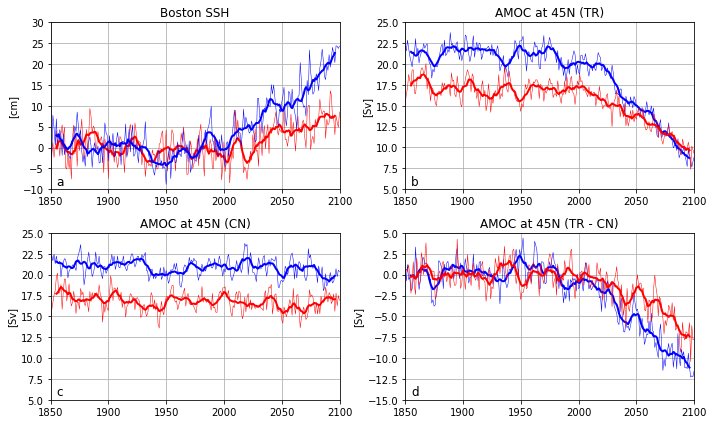

In [27]:
fig1, axs = plt.subplots(2,2,figsize=(10, 6))
# fig, axs = plot.subplots(nrows=3, ncols=2, width='12in', height='10in')

yrs = np.arange(1850,2100+1,1)
# row 1: Boston
# axs[0,0].plot(yrs, ssh_yra_TH.isel(nlon_t=0,nlat_t=0), color='r', 
#             linewidth=0.5)
# axs[0,0].plot(yrs, ssh_yra_TH.isel(nlon_t=0,nlat_t=0).rolling(time=10, center=True).mean(), color='r', 
#             linewidth=2.5, label="HR")
# axs[0,0].plot(yrs, ssh_yra_TL.isel(nlon_t=0,nlat_t=0), color='b', 
#             linewidth=0.5)
# axs[0,0].plot(yrs, ssh_yra_TL.isel(nlon_t=0,nlat_t=0).rolling(time=10, center=True).mean(), color='b', 
#             linewidth=2.5, label="LR")
# axs[0,0].set_xlim([1850,2100])
# axs[0,0].set_ylim([-10,30])
# # axs[0,0].set_xticks(np.arange(1850, 2100+1,50))
# # axs[0,0].set_xticklabels(np.arange(1850, 2100+1,50), fontsize=12)
# # axs[0,0].set_yticks(np.arange(-10, 30+1,5))
# # axs[0,0].set_yticklabels(np.arange(-10, 30+1,5), fontsize=12)
# axs[0,0].grid()
# axs[0,0].set_ylabel('SSHA [cm]')
# axs[0,0].set_title('Boston (TR)')
# axs[0,0].text(1855, -9, 'a', fontsize=12)
# axs[0,0].legend()

# axs[0,1].plot(yrs, ssh_yra_CH.isel(nlon_t=0,nlat_t=0), color='r', 
#             linewidth=0.5, linestyle='-',label="HR")
# axs[0,1].plot(yrs, ssh_yra_CH.isel(nlon_t=0,nlat_t=0).rolling(time=10, center=True).mean(), color='r', 
#             linewidth=2.5, linestyle='-',label="HR")
# axs[0,1].plot(yrs, ssh_yra_CL.isel(nlon_t=0,nlat_t=0), color='b', 
#             linewidth=0.5, linestyle='-',label="LR")
# axs[0,1].plot(yrs, ssh_yra_CL.isel(nlon_t=0,nlat_t=0).rolling(time=10, center=True).mean(), color='b', 
#             linewidth=2.5, linestyle='-',label="LR")
# axs[0,1].set_xlim([1850,2100])
# axs[0,1].set_ylim([-10,30])
# axs[0,1].set_title('Boston (CN)')
# axs[0,1].grid()
# axs[0,1].text(1855, -9, 'b', fontsize=12)

ssh_yraB_THmCH = ssh_yra_TH.isel(nlon_t=0,nlat_t=0) - ssh_yra_CH.isel(nlon_t=0,nlat_t=0) # B: Boston
ssh_yraB_TLmCL = ssh_yra_TL.isel(nlon_t=0,nlat_t=0) - ssh_yra_CL.isel(nlon_t=0,nlat_t=0)
axs[0,0].plot(yrs, ssh_yraB_THmCH, color='r', 
            linewidth=0.5, linestyle='-',label="HR")
axs[0,0].plot(yrs, ssh_yraB_THmCH.rolling(time=10, center=True).mean(), color='r', 
            linewidth=2, linestyle='-',label="HR")
axs[0,0].plot(yrs, ssh_yraB_TLmCL, color='b', 
            linewidth=0.5, linestyle='-',label="LR")
axs[0,0].plot(yrs, ssh_yraB_TLmCL.rolling(time=10, center=True).mean(), color='b', 
            linewidth=2, linestyle='-',label="LR")
axs[0,0].set_xlim([1850,2100])
axs[0,0].set_ylim([-10,30])
axs[0,0].set_ylabel('[cm]')
axs[0,0].set_title('Boston SSH')
axs[0,0].grid()
axs[0,0].text(1855, -9, 'a', fontsize=12)

# row 2: New Yok 
# axs[1,0].plot(yrs, ssh_yra_TH.isel(nlon_t=1,nlat_t=1), color='r', 
#             linewidth=0.5, label="HR")
# axs[1,0].plot(yrs, ssh_yra_TH.isel(nlon_t=1,nlat_t=1).rolling(time=10, center=True).mean(), color='r', 
#             linewidth=2, label="HR")
# axs[1,0].plot(yrs, ssh_yra_TL.isel(nlon_t=1,nlat_t=1), color='b', 
#             linewidth=0.5, label="LR")
# axs[1,0].plot(yrs, ssh_yra_TL.isel(nlon_t=1,nlat_t=1).rolling(time=10, center=True).mean(), color='b', 
#             linewidth=2, label="LR")
# axs[1,0].set_xlim([1850,2100])
# axs[1,0].set_ylim([-10,25])
# axs[1,0].set_ylabel('SSHA [cm]')
# axs[1,0].set_title('New York (TR)')
# axs[1,0].grid()
# axs[1,0].text(1855, -9, 'd', fontsize=12)

# axs[1,1].plot(yrs, ssh_yra_CH.isel(nlon_t=1,nlat_t=1), color='r', 
#             linewidth=0.5, linestyle='-',label="HR")
# axs[1,1].plot(yrs, ssh_yra_CH.isel(nlon_t=1,nlat_t=1).rolling(time=10, center=True).mean(), color='r', 
#             linewidth=2, linestyle='-',label="HR")
# axs[1,1].plot(yrs, ssh_yra_CL.isel(nlon_t=1,nlat_t=1), color='b', 
#             linewidth=0.5, linestyle='-',label="LR")
# axs[1,1].plot(yrs, ssh_yra_CL.isel(nlon_t=1,nlat_t=1).rolling(time=10, center=True).mean(), color='b', 
#             linewidth=2, linestyle='-',label="LR")
# axs[1,1].set_xlim([1850,2100])
# axs[1,1].set_ylim([-10,25])
# axs[1,1].set_title('New York (CN)')
# axs[1,1].grid()
# axs[1,1].text(1855, -9, 'e', fontsize=12)

# ssh_yraN_THmCH = ssh_yra_TH.isel(nlon_t=1,nlat_t=1) - ssh_yra_CH.isel(nlon_t=1,nlat_t=1) # N: New York
# ssh_yraN_TLmCL = ssh_yra_TL.isel(nlon_t=1,nlat_t=1) - ssh_yra_CL.isel(nlon_t=1,nlat_t=1)
# axs[1,2].plot(yrs, ssh_yraN_THmCH, color='r',
#             linewidth=0.5, linestyle='-',label="HR")
# axs[1,2].plot(yrs, ssh_yraN_THmCH.rolling(time=10, center=True).mean(), color='r',
#             linewidth=2, linestyle='-',label="HR")
# axs[1,2].plot(yrs, ssh_yraN_TLmCL, color='b', 
#             linewidth=0.5, linestyle='-',label="LR")
# axs[1,2].plot(yrs, ssh_yraN_TLmCL.rolling(time=10, center=True).mean(), color='b', 
#             linewidth=2, linestyle='-',label="LR")
# axs[1,2].set_xlim([1850,2100])
# axs[1,2].set_ylim([-11,25])
# axs[1,2].set_title('New York (TR - CN)')
# axs[1,2].grid()
# axs[1,2].text(1855, -10, 'f', fontsize=12)

# row 3: MOC
axs[0,1].plot(yrs, MOC45_yr_TL, color='b', linewidth=0.5, label="TR LR")
axs[0,1].plot(yrs, MOC45_yr_TL.rolling(time=10, center=True).mean(), color='b', linewidth=2, label="TR LR")
axs[0,1].plot(yrs, MOC45_yr_TH, color='r', linewidth=0.5, label="TR HR")
axs[0,1].plot(yrs, MOC45_yr_TH.rolling(time=10, center=True).mean(), color='r', linewidth=2, label="TR HR")
axs[0,1].set_xlim([1850,2100])
axs[0,1].set_ylim([5,25])
axs[0,1].set_ylabel('[Sv]')
axs[0,1].set_title('AMOC at 45N (TR)')
axs[0,1].grid()
axs[0,1].text(1855, 5.5, 'b', fontsize=12)

axs[1,0].plot(yrs, MOC45_yr_CL, color='b', linestyle='-', 
            linewidth=0.5, label="CN LR")
axs[1,0].plot(yrs, MOC45_yr_CL.rolling(time=10, center=True).mean(), color='b', linestyle='-', 
            linewidth=2, label="CN LR")
axs[1,0].plot(yrs, MOC45_yr_CH, color='r', linestyle='-', 
            linewidth=0.5, label="CN HR")
axs[1,0].plot(yrs, MOC45_yr_CH.rolling(time=10, center=True).mean(), color='r', linestyle='-', 
            linewidth=2, label="CN HR")
axs[1,0].set_xlim([1850,2100])
axs[1,0].set_ylim([5,25])
axs[1,0].set_ylabel('[Sv]')
axs[1,0].set_title('AMOC at 45N (CN)')
axs[1,0].grid()
axs[1,0].text(1855, 5.5, 'c', fontsize=12)

MOC45_yr_TLmCL = MOC45_yr_TL - MOC45_yr_CL
MOC45_yr_THmCH = MOC45_yr_TH - MOC45_yr_CH
axs[1,1].plot(yrs, MOC45_yr_TLmCL, 
              color='b', linestyle='-', linewidth=0.5, label="CN LR")
axs[1,1].plot(yrs, MOC45_yr_TLmCL.rolling(time=10, center=True).mean(), 
              color='b', linestyle='-', linewidth=2, label="CN LR")
axs[1,1].plot(yrs, MOC45_yr_THmCH, color='r', linestyle='-', 
            linewidth=0.5, label="CN HR")
axs[1,1].plot(yrs, MOC45_yr_THmCH.rolling(time=10, center=True).mean().values, 
              color='r', linestyle='-', 
            linewidth=2, label="CN HR")
axs[1,1].set_xlim([1850,2100])
axs[1,1].set_ylim([-15,5])
axs[1,1].set_ylabel('[Sv]')
axs[1,1].set_title('AMOC at 45N (TR - CN)')
axs[1,1].grid()
axs[1,1].text(1855, -14.5, 'd', fontsize=12)

fig1.tight_layout()

fig1.savefig(pic1,bbox_inches='tight')

compute regression statistics

In [22]:
# # Boston
# pfB_TH = np.polyfit(MOC45_yr_TH.sel(time=slice('2000','2100')), 
#                     ssh_yr_TH.isel(nlon_t=0, nlat_t=0).sel(time=slice('2000','2100')), deg=1) # pf: polyfit, B: Boston
# pfB_TL = np.polyfit(MOC45_yr_TL.sel(time=slice('2000','2100')), 
#                     ssh_yr_TL.isel(nlon_t=0, nlat_t=0).sel(time=slice('2000','2100')), deg=1)

# print('Boston, SSH2AMOC(TH):', pfB_TH[0])
# print('Boston, SSH2AMOC(TL):', pfB_TL[0])

# # New York
# pfN_TH = np.polyfit(MOC45_yr_TH.sel(time=slice('2000','2100')), 
#                     ssh_yr_TH.isel(nlon_t=1, nlat_t=1).sel(time=slice('2000','2100')), deg=1)# pf: polyfit, N: New York
# pfN_TL = np.polyfit(MOC45_yr_TL.sel(time=slice('2000','2100')), 
#                     ssh_yr_TL.isel(nlon_t=1, nlat_t=1).sel(time=slice('2000','2100')), deg=1)
# print('New York, SSH2AMOC(TH):', pfN_TH[0])
# print('New York, SSH2AMOC(TL):', pfN_TL[0])

Boston, SSH2AMOC(TH): -1.1575294817509472
Boston, SSH2AMOC(TL): -1.732173291130704
New York, SSH2AMOC(TH): -0.9538831050745664
New York, SSH2AMOC(TL): -1.480499361030324


In [23]:
# 1.7/1.2, 1.5/1

(1.4166666666666667, 1.5)

# Appendix

<xarray.DataArray 'MOC' (time: 251)>
array([       nan,        nan,        nan,        nan,        nan,
       21.465704 , 21.340591 , 21.371397 , 21.096916 , 21.00891  ,
       21.04873  , 21.176058 , 21.453896 , 21.561285 , 21.659975 ,
       21.599672 , 21.594584 , 21.4091   , 21.394598 , 21.127113 ,
       20.926096 , 20.669508 , 20.42333  , 20.203775 , 19.951452 ,
       19.752651 , 19.79608  , 19.999819 , 20.240835 , 20.511734 ,
       20.860397 , 21.057102 , 21.178106 , 21.384623 , 21.55699  ,
       21.888762 , 21.987598 , 22.026472 , 21.958586 , 21.99038  ,
       21.940039 , 22.107779 , 22.151659 , 22.026365 , 22.039167 ,
       21.701582 , 21.581964 , 21.482239 , 21.659212 , 21.854877 ,
       21.831228 , 21.685303 , 21.550972 , 21.596098 , 21.659742 ,
       21.959295 , 21.932745 , 21.9718   , 21.885035 , 21.70825  ,
       21.747694 , 21.859287 , 21.885412 , 21.888868 , 21.844263 ,
       21.68221  , 21.783566 , 21.790842 , 21.74317  , 21.770529 ,
       21.627493 , 21.628048 , 21.676262 , 21.754284 , 21.67699  ,
       21.660746 , 21.697468 , 21.628035 , 21.330564 , 21.124674 ,
       21.016928 , 20.88436  , 20.694185 , 20.478624 , 20.288221 ,
       19.969887 , 19.816097 , 19.697271 , 19.875143 , 19.966354 ,
       20.103285 , 20.285465 , 20.619425 , 20.816626 , 20.968237 ,
       21.402102 , 21.613667 , 21.894306 , 22.134542 , 22.215662 ,
...
       20.039991 , 20.094772 , 20.205658 , 20.020336 , 19.90861  ,
       19.804508 , 19.67461  , 19.590567 , 19.690044 , 19.859758 ,
       20.083761 , 20.047789 , 20.027988 , 20.091413 , 19.957352 ,
       19.885294 , 19.918139 , 19.769047 , 19.49354  , 19.220268 ,
       19.128433 , 19.108683 , 18.894947 , 18.554594 , 18.3504   ,
       18.120596 , 17.796974 , 17.606588 , 17.444864 , 17.160715 ,
       16.673079 , 16.188627 , 16.04868  , 15.957354 , 15.856433 ,
       15.707291 , 15.682678 , 15.514964 , 15.288569 , 15.360489 ,
       15.436356 , 15.521209 , 15.409446 , 15.306676 , 15.111785 ,
       15.050219 , 14.92266  , 14.795044 , 14.637858 , 14.471393 ,
       14.446097 , 14.402344 , 14.29086  , 14.269037 , 14.405112 ,
       14.377376 , 14.37213  , 14.2261505, 14.150469 , 13.8455   ,
       13.421599 , 13.239203 , 13.183316 , 12.874977 , 12.539259 ,
       12.324936 , 11.989116 , 11.866236 , 11.793258 , 11.948998 ,
       11.94803  , 11.824878 , 11.573918 , 11.451637 , 11.307197 ,
       11.168439 , 10.995036 , 10.961757 , 10.669341 , 10.292371 ,
       10.137023 ,  9.9194565,  9.850417 ,  9.765176 ,  9.594551 ,
        9.316627 ,  9.33224  ,  9.109698 ,  9.077841 ,  8.922771 ,
        8.784421 ,  8.734004 ,        nan,        nan,        nan,
              nan], dtype=float32)
Coordinates:
  * time          (time) object 1850-12-31 00:00:00 ... 2100-12-31 00:00:00
    lat_aux_grid  float32 44.76
    moc_z         float32 1.041e+05

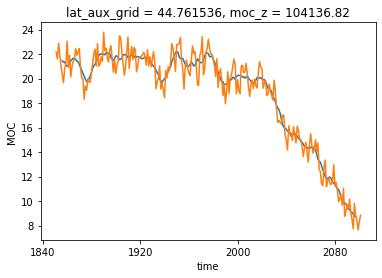

In [31]:
# MOC45_yr_TL.rolling(time=20, center=True).mean().dropna("time")#.plot()
MOC45_yr_TL.rolling(time=10, center=True).mean().dropna("time").plot()
MOC45_yr_TL#.plot()
MOC45_yr_TL.plot()
MOC45_yr_TL.rolling(time=10, center=True).mean()#.dropna('time').time

plot original SSH 

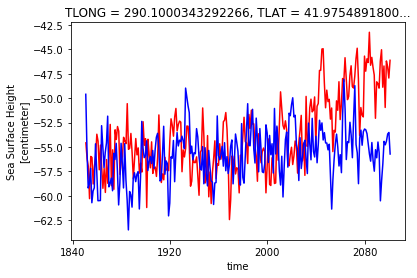

In [23]:
ssh_yr_TH.isel(nlon_t=0,nlat_t=0).plot(color='r')
ssh_yr_CH.isel(nlon_t=0,nlat_t=0).plot(color='b')

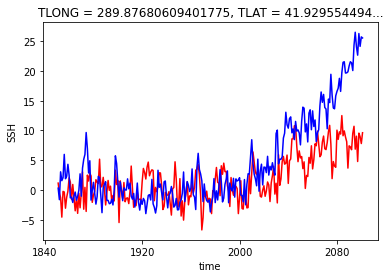

In [24]:
(ssh_yr_TH.isel(nlon_t=0,nlat_t=0) - 
 ssh_yr_TH.isel(nlon_t=0,nlat_t=0).sel(time=slice('1850','1950')).mean('time')).plot(color='r')
(ssh_yr_TL.isel(nlon_t=0,nlat_t=0) - 
ssh_yr_TL.isel(nlon_t=0,nlat_t=0).sel(time=slice('1850','1950')).mean('time')).plot(color='b')

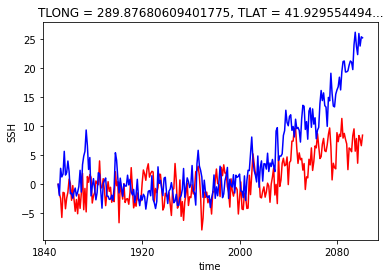

In [25]:
(ssh_yr_TH.isel(nlon_t=0,nlat_t=0) - 
 ssh_yr_TH.isel(nlon_t=0,nlat_t=0).isel(time=0)).plot(color='r')
(ssh_yr_TL.isel(nlon_t=0,nlat_t=0) - 
ssh_yr_TL.isel(nlon_t=0,nlat_t=0).isel(time=0)).plot(color='b')

check MOC coordinates 

In [26]:
ds_MOC_TH.MOC

<xarray.DataArray 'MOC' (time: 3012, transport_reg: 2, moc_comp: 1, moc_z: 63, lat_aux_grid: 395)>
[149907240 values with dtype=float32]
Coordinates:
  * time               (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  (transport_reg) |S256 b'Global Ocean - Marginal Seas' ...
    moc_components     (moc_comp) |S256 b'Eulerian Mean'
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: transport_reg, moc_comp
Attributes:
    units:      Sverdrups
    long_name:  Meridional Overturning Circulation

In [27]:
ds_MOC_TH.MOC.sel(lat_aux_grid=45, moc_z=1000*100,
             method='nearest').sel(moc_comp=0, transport_reg=1)

<xarray.DataArray 'MOC' (time: 3012)>
array([11.917703, 15.644326, 16.27959 , ...,  9.647427, 11.984182,  8.552816],
      dtype=float32)
Coordinates:
  * time               (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador ...
    moc_components     |S256 b'Eulerian Mean'
    moc_z              float32 1.041e+05
    lat_aux_grid       float32 44.76
Attributes:
    units:      Sverdrups
    long_name:  Meridional Overturning Circulation